In [1]:
SITE_ID    = "therealdeal.com"
API_SECRET = "Z5evAX56zI2htaKNk36665zSaJEcIGYiCZjeI7jpUzI"

Month Jan: fetched 0 posts
Month Feb: fetched 0 posts
Month Mar: fetched 16049 posts
Month Apr: fetched 17018 posts
Month May: fetched 16976 posts
Month Jun: fetched 16402 posts


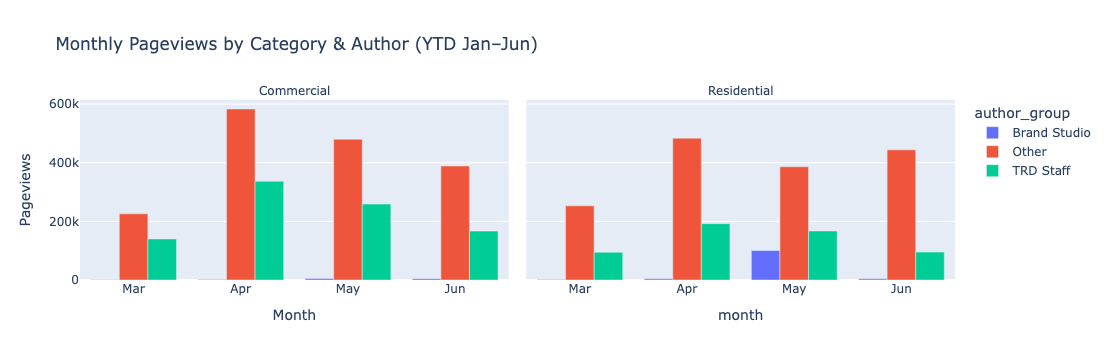

In [5]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import calendar
import plotly.express as px

# ─── UTILITIES ──────────────────────────────────────────────────────────────
def fetch_posts(start: datetime, end: datetime) -> pd.DataFrame:
    """
    Fetch posts across all geographic sections between start and end.
    Returns a DataFrame with columns: url, section, author, tags, metrics.views
    """
    # 1) Fetch section slugs
    secs_url = "https://api.parsely.com/v2/analytics/sections"
    secs_params = {
        "apikey": SITE_ID,
        "secret": API_SECRET,
        "period_start": start.replace(microsecond=0).isoformat(),
        "period_end":   end.replace(microsecond=0).isoformat(),
        "limit": 1000,
        "page": 1
    }
    r = requests.get(secs_url, params=secs_params)
    r.raise_for_status()
    sections = [rec["section"] for rec in r.json().get("data", [])]

    # 2) Pull posts for each section
    posts_url = "https://api.parsely.com/v2/analytics/posts"
    all_posts = []
    for section in sections:
        resp = requests.get(posts_url, params={
            "apikey": SITE_ID,
            "secret": API_SECRET,
            "section": section,
            "period_start": start.replace(microsecond=0).isoformat() + "Z",
            "period_end":   end.replace(microsecond=0).isoformat() + "Z",
            "limit": 2000,
            "sort": "views"
        })
        resp.raise_for_status()
        data = resp.json().get("data", [])
        for post in data:
            post["section"] = section
            # Normalize tags
            raw_tags = post.get("tags", [])
            norm = []
            for t in raw_tags:
                if isinstance(t, dict):
                    tag = t.get("tag") or t.get("name")
                    if tag:
                        norm.append(tag)
                elif isinstance(t, str):
                    norm.append(t)
            post["tags"] = norm
        all_posts.extend(data)

    df = pd.json_normalize(all_posts)
    # ensure URL column
    if "url" not in df.columns and "canonical_url" in df.columns:
        df.rename(columns={"canonical_url": "url"}, inplace=True)
    # flatten views
    df["views"] = df.get("metrics.views", 0)
    # ensure tags and author columns exist
    if "tags" not in df.columns:
        df["tags"] = [[] for _ in range(len(df))]
    if "author" not in df.columns:
        df["author"] = None
    return df


def classify(tags: list) -> str:
    tags_lower = [t.lower() for t in (tags or [])]
    if any("residential" in t for t in tags_lower): return "Residential"
    if any("commercial" in t for t in tags_lower):  return "Commercial"
    return None

# ─── DEFINE DATE RANGE ───────────────────────────────────────────────────────
now = datetime.utcnow().replace(microsecond=0)
year = now.year
periods = []
for m in range(1, now.month + 1):
    start = datetime(year, m, 1)
    end = datetime(year, m+1, 1) - timedelta(seconds=1) if m < now.month else now
    label = calendar.month_abbr[m]
    periods.append((start, end, label))

# ─── AGGREGATE PAGEVIEWS BY MONTH, CATEGORY & AUTHOR GROUP ──────────────────
summary_list = []
for start, end, label in periods:
    df_m = fetch_posts(start, end)
    print(f"Month {label}: fetched {len(df_m)} posts")
    df_m["classification"] = df_m["tags"].apply(classify)
    df_m["author_group"] = df_m["author"].apply(
        lambda a: "TRD Staff" if a == "TRD Staff" else (
                  "Brand Studio" if a == "Brand Studio" else "Other"))
    # filter only classified
    df_m = df_m[df_m["classification"].notnull()]
    # group by classification + author_group
    agg = (
        df_m.groupby(["classification","author_group"], dropna=False)
            .agg(pageviews=("views","sum"))
            .reset_index()
    )
    agg["month"] = label
    summary_list.append(agg)

# Combine
df_summary = pd.concat(summary_list, ignore_index=True) if summary_list else pd.DataFrame(
    columns=["classification","author_group","pageviews","month"]
)

# ─── PLOT ───────────────────────────────────────────────────────────────────
month_order = [label for _,_,label in periods]
fig = px.bar(
    df_summary,
    x="month",
    y="pageviews",
    color="author_group",
    facet_col="classification",
    category_orders={"month": month_order},
    barmode="group",
    title=f"Monthly Pageviews by Category & Author (YTD Jan–{calendar.month_abbr[now.month]})"
)
fig.update_layout(xaxis_title="Month", yaxis_title="Pageviews")
# Simplify facet titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.write_html("index.html")
fig.show()


In [3]:
df_summary

,classification,author_group,pageviews,month
0,Commercial,Brand Studio,607,Mar
1,Commercial,Other,225605,Mar
2,Commercial,TRD Staff,139991,Mar
3,Residential,Brand Studio,1663,Mar
4,Residential,Other,252908,Mar
5,Residential,TRD Staff,94490,Mar
6,Commercial,Brand Studio,1344,Apr
7,Commercial,Other,583237,Apr
8,Commercial,TRD Staff,336754,Apr
9,Residential,Brand Studio,4417,Apr


In [7]:
import os

base_name = 'https://trd-digital.github.io/trd-news-interactive-maps/'

cwd = os.getcwd()

cwd = cwd.split('/')

final_name = base_name + cwd[-1]
print(final_name)

https://trd-digital.github.io/trd-news-interactive-maps/TRD_Parsely_Dataviz_timeseries


In [8]:
# # Ensure consistent month order
# month_order = [label for _, _, label in periods]

# # ─── PLOT ───────────────────────────────────────────────────────────────────
# fig = px.bar(
#     df_summary,
#     x="month",
#     y="pageviews",
#     color="classification",
#     barmode="group",
#     category_orders={"month": month_order},
#     title=f"Pageviews by Residential vs Commercial (Year-to-Date: Jan–{calendar.month_abbr[now.month]})"
# )
# fig.update_layout(xaxis_title="Month", yaxis_title="Pageviews")
# fig.show()